In [1]:
import os
import cv2
import json
import matplotlib.pyplot as plt
import os
import json
import shutil
import random
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2025-01-22 01:38:57.156908: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-22 01:38:57.181651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737490137.198895    9960 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737490137.202357    9960 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 01:38:57.231189: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Extract Data from all folders 

In [24]:
import os
import shutil
import json
import cv2
import matplotlib.pyplot as plt

folders = [
    r"E:\Our_Dataset\Data Folders\Pcb Image\Pcb Image 1",
    r"E:\Our_Dataset\Data Folders\Pcb Image 2\Pcb Image 2",
    r"E:\Our_Dataset\Data Folders\Pcb Image 3\Pcb Image 3",
    r"E:\Our_Dataset\Data Folders\Pcb Image 4\Pcb Image 4",
    r"E:\Our_Dataset\Data Folders\Pcb Image 5\Pcb Image 5",
    r"E:\Our_Dataset\Data Folders\Pcb Image 6\Pcb Image 6",
    r"E:\Our_Dataset\Data Folders\Pcb Image 7\Pcb Image 7",
    r"E:\Our_Dataset\Data Folders\Pcb Image 8\Pcb Image 8",
    r"E:\Our_Dataset\Data Folders\Pcb Image 9\Pcb Image 9",
    r"E:\Our_Dataset\Data Folders\Pcb Image 10\Pcb Image 10",
    r"E:\Our_Dataset\Data Folders\Pcb Image 11\Pcb Image 11",
    r"E:\Our_Dataset\Data Folders\Pcb Image 12\Pcb Image 12",
]
target_folder = r"E:\Our_Dataset\Combined_Pcb_Images"
os.makedirs(target_folder, exist_ok=True)

counter = 1
for folder in folders:
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        
        # Check if it's an image or JSON file
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            new_image_name = f"image_{counter}.png"
            shutil.copy(filepath, os.path.join(target_folder, new_image_name))
            
            # Check for corresponding JSON
            json_filepath = os.path.join(folder, f"{os.path.splitext(filename)[0]}.json")
            if os.path.exists(json_filepath):
                new_json_name = f"image_{counter}.json"
                shutil.copy(json_filepath, os.path.join(target_folder, new_json_name))
            
            counter += 1

## Rename, Crop and Save

In [30]:
import os
import json

# Define paths
target_folder = r"E:\Our_Dataset\Combined_Pcb_Images"

# Define class renaming and combining rules
rename_rules = {
    "Solder maximum": "Excess solder",
    "Extra solder": "Excess solder",
    "Mis align component": "Component positional problem",
    "Mising align component": "Component positional problem",
    "Mising component": "Missing component",
    "Worng Polarity": "Unknown fault",
    "Bridge": "Unknown fault",
    "Upside Down Component": "Unknown fault",
    "Worng component": "Wrong component",
}

# Process all JSON files in the target folder
for file_name in os.listdir(target_folder):
    if file_name.endswith(".json"):
        json_file_path = os.path.join(target_folder, file_name)
        
        # Load the JSON file
        with open(json_file_path, "r") as file:
            data = json.load(file)

        # Update class names
        modified = False
        for shape in data.get("shapes", []):  # Assuming "shapes" holds annotation info
            current_label = shape.get("label")
            if current_label in rename_rules:
                print(f"File: {file_name} | Changing '{current_label}' to '{rename_rules[current_label]}'")
                shape["label"] = rename_rules[current_label]
                modified = True

        # Save the updated JSON if changes were made
        if modified:
            with open(json_file_path, "w") as file:
                json.dump(data, file, indent=4)
            print(f"File: {file_name} updated successfully.\n")
        else:
            print(f"File: {file_name} had no changes.\n")

print("All JSON files processed!")


File: image_1.json had no changes.

File: image_10.json had no changes.

File: image_100.json had no changes.

File: image_101.json had no changes.

File: image_102.json had no changes.

File: image_103.json had no changes.

File: image_104.json had no changes.

File: image_105.json had no changes.

File: image_106.json had no changes.

File: image_107.json had no changes.

File: image_108.json had no changes.

File: image_109.json had no changes.

File: image_11.json had no changes.

File: image_110.json had no changes.

File: image_111.json had no changes.

File: image_112.json had no changes.

File: image_113.json had no changes.

File: image_114.json had no changes.

File: image_115.json had no changes.

File: image_116.json had no changes.

File: image_117.json had no changes.

File: image_118.json had no changes.

File: image_119.json had no changes.

File: image_12.json had no changes.

File: image_120.json had no changes.

File: image_121.json had no changes.

File: image_122.j

In [34]:
def crop_and_save_components(annotation_folder, output_folder):
    for filename in os.listdir(annotation_folder):
        if filename.endswith(".json"):
            json_path = os.path.join(annotation_folder, filename)
            image_path = os.path.join(annotation_folder, filename.replace(".json", ".png"))
            if not os.path.exists(image_path):
                continue
            
            # Load image and JSON
            image = cv2.imread(image_path)
            if image is None:
                print(f"Failed to load image: {image_path}")
                continue
            
            with open(json_path, "r") as f:
                annotations = json.load(f)
            
            for i, shape in enumerate(annotations["shapes"]):
                points = shape["points"]
                label = shape["label"]
                
                # Same logic as rectangle drawing
                start_point = tuple(map(int, points[0]))
                end_point = tuple(map(int, points[1]))
                
                # Normalize to top-left and bottom-right
                x1, y1 = min(start_point[0], end_point[0]), min(start_point[1], end_point[1])
                x2, y2 = max(start_point[0], end_point[0]), max(start_point[1], end_point[1])
                
                # Clip coordinates to the image dimensions
                height, width = image.shape[:2]
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(width, x2), min(height, y2)
                
                # Check if the box is valid
                if x1 >= x2 or y1 >= y2:
                    print(f"Invalid bounding box for {filename}: {points}")
                    continue
                
                cropped = image[y1:y2, x1:x2]
                
                # Create a folder for the label
                label_folder = os.path.join(output_folder, label)
                os.makedirs(label_folder, exist_ok=True)
                
                # Save the cropped image
                crop_filename = f"{filename.replace('.json', '')}_component_{i}.png"
                cv2.imwrite(os.path.join(label_folder, crop_filename), cropped)

                
annotation_folder = r"E:\Our_Dataset\Combined_Pcb_Images"
output_folder = r"E:\Our_Dataset\Cropped_Components"
os.makedirs(output_folder, exist_ok=True)
crop_and_save_components(annotation_folder, output_folder)


def count_images_in_folders(base_folder):
    fault_counts = {}
    
    # Iterate through subfolders in the base folder
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        
        # Check if it's a directory
        if os.path.isdir(label_path):
            # Count the number of image files in the folder
            image_count = len([file for file in os.listdir(label_path) if file.endswith(('.png', '.jpg', '.jpeg'))])
            fault_counts[label_folder] = image_count
    
    # Print the results
    for fault, count in fault_counts.items():
        print(f"{fault}: {count} images")
    
    return fault_counts

# Specify the output folder where cropped images are stored
output_folder = r"E:\Our_Dataset\Cropped_Components"
fault_image_counts = count_images_in_folders(output_folder)

Component positional problem: 117 images
Component shifted: 442 images
Excess solder: 102 images
Good Solder: 1561 images
Missing component: 369 images
Pseudo solder: 101 images
Solder insufficient: 361 images
Tombstone: 49 images
Unknown fault: 39 images
Wrong component: 116 images


## Yolo component detection

In [17]:
# Paths
input_path = r"E:\Our_Dataset\Combined_Pcb_Images"  
output_path = r"E:\Our_Dataset\YOLO_Format"

# Create required output folders
image_train_path = os.path.join(output_path, "images", "train")
label_train_path = os.path.join(output_path, "labels", "train")
image_val_path = os.path.join(output_path, "images", "val")
label_val_path = os.path.join(output_path, "labels", "val")
os.makedirs(image_train_path, exist_ok=True)
os.makedirs(label_train_path, exist_ok=True)
os.makedirs(image_val_path, exist_ok=True)
os.makedirs(label_val_path, exist_ok=True)

# Gather all JSON files and corresponding image files
dataset_files = []
for file in os.listdir(input_path):
    if file.endswith(".json"):
        json_path = os.path.join(input_path, file)
        image_name = file.replace(".json", ".png")  
        image_path = os.path.join(input_path, image_name)

        
        if not os.path.exists(image_path):
            print(f"Missing image for {file}, skipping.")
            continue

        dataset_files.append((json_path, image_path))

# Shuffle and split the dataset into training and validation sets
random.seed(42)  
random.shuffle(dataset_files)
split_index = int(len(dataset_files) * 0.7)
train_files = dataset_files[:split_index]
val_files = dataset_files[split_index:]

def process_files(files, image_output_path, label_output_path):
    for json_path, image_path in files:
        with open(json_path, "r") as f:
            data = json.load(f)

       
        img_width = data.get("imageWidth")
        img_height = data.get("imageHeight")
        if not img_width or not img_height:
            print(f"Missing image dimensions in {json_path}, skipping.")
            continue

        # Convert annotations to YOLO format
        yolo_annotations = []
        for shape in data["shapes"]:
            if shape["shape_type"] == "rectangle":
                x_min, y_min = shape["points"][0]
                x_max, y_max = shape["points"][1]

              
                x_center = ((x_min + x_max) / 2) / img_width
                y_center = ((y_min + y_max) / 2) / img_height
                width = (x_max - x_min) / img_width
                height = (y_max - y_min) / img_height

          
                yolo_annotations.append(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

        # Save YOLO annotations
        label_file = os.path.join(label_output_path, os.path.basename(json_path).replace(".json", ".txt"))
        with open(label_file, "w") as f:
            f.write("\n".join(yolo_annotations))

        # Copy image to the appropriate directory
        output_image_path = os.path.join(image_output_path, os.path.basename(image_path))
        shutil.copy(image_path, output_image_path)

# Process training and validation files
process_files(train_files, image_train_path, label_train_path)
process_files(val_files, image_val_path, label_val_path)

print("Dataset conversion and splitting complete.")

Dataset conversion and splitting complete.


In [21]:
from ultralytics import YOLO
import os

# Paths
dataset_path = r"E:\Our_Dataset\YOLO_Format"
data_yaml = os.path.join(dataset_path, "data.yaml")

# Generate data.yaml
data_yaml_content = f"""
train: {os.path.join(dataset_path, 'images/train')}
val: {os.path.join(dataset_path, 'images/val')}
nc: 1
names: ['component']  # Single class for ROI
"""
with open(data_yaml, "w") as f:
    f.write(data_yaml_content)

# Load a pretrained YOLOv8 model
model = YOLO('yolov8n.pt')  

# Train the model
model.train(
    data=data_yaml,      # Path to data.yaml
    epochs=20,           # Number of epochs
    imgsz=1280,          # Adjusted to fit dataset image dimensions
    batch=16,            # Batch size
    workers=7,           # Adjust based on your CPU/GPU
    name="pcb_detection" # Save run with this name
)

# Validate the model
metrics = model.val()

New https://pypi.org/project/ultralytics/8.3.65 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.56  Python-3.12.4 torch-2.5.1+cpu CPU (Intel Core(TM) Ultra 7 155H)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=E:\Our_Dataset\YOLO_Format\data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=7, project=None, name=pcb_detection6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sho

train: Scanning E:\Our_Dataset\YOLO_Format\labels\train.cache... 127 images, 0 backgrounds, 55 corrupt: 100%|██████████

train: WARNING  E:\Our_Dataset\YOLO_Format\images\train\image_1.png: ignoring corrupt image/label: negative label values [   -0.13672    -0.13902    -0.14131    -0.14476]
train: WARNING  E:\Our_Dataset\YOLO_Format\images\train\image_101.png: ignoring corrupt image/label: negative label values [  -0.060955    -0.05237   -0.066106   -0.097871    -0.10302   -0.067823   -0.060955    -0.06353   -0.065247]
train: WARNING  E:\Our_Dataset\YOLO_Format\images\train\image_102.png: ignoring corrupt image/label: negative label values [  -0.066964    -0.19059   -0.072974    -0.06954    -0.17514   -0.060096   -0.064389    -0.18286   -0.065247   -0.059238   -0.097871   -0.088427   -0.089286    -0.10045   -0.089286   -0.090144   -0.096154    -0.08671   -0.088427    -0.10817   -0.097012   -0.097871   -0.042067   -0.036916    -0.10474   -0.048077
   -0.044643   -0.099588   -0.042067   -0.042926   -0.099588   -0.041209   -0.041209    -0.10474   -0.047218    -0.04636    -0.10731   -0.048935   -0.041209]
tr


val: Scanning E:\Our_Dataset\YOLO_Format\labels\val.cache... 55 images, 0 backgrounds, 33 corrupt: 100%|██████████| 55/

val: WARNING  E:\Our_Dataset\YOLO_Format\images\val\image_104.png: ignoring corrupt image/label: negative label values [   -0.17857    -0.06353    -0.18029   -0.062672   -0.066106    -0.17685   -0.065247   -0.066964    -0.17514   -0.060955   -0.066106   -0.099588   -0.075827   -0.097871    -0.17428   -0.065247   -0.067823]
val: WARNING  E:\Our_Dataset\YOLO_Format\images\val\image_105.png: ignoring corrupt image/label: negative label values [  -0.094437    -0.10131   -0.093578   -0.094437    -0.10302   -0.094437    -0.18372   -0.071257   -0.062672    -0.16999   -0.066106   -0.057521    -0.18544   -0.070398   -0.066106      -0.176   -0.064389   -0.066964    -0.18544   -0.067823   -0.068681    -0.17771   -0.072115   -0.070398    -0.10216   -0.094437
   -0.080423   -0.089286]
val: WARNING  E:\Our_Dataset\YOLO_Format\images\val\image_106.png: ignoring corrupt image/label: negative label values [   -0.11418    -0.10131   -0.082721    -0.10474    -0.11247   -0.099588    -0.09421   -0.098729  

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 1280 train, 1280 val
Using 0 dataloader workers
Logging results to runs\detect\pcb_detection6
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      1.402      2.632      1.413         95       1280: 100%|██████████| 5/5 [03:04<00:00, 36.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<0

                   all         22        185     0.0227      0.811      0.548       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      1.234      2.099      1.293         89       1280: 100%|██████████| 5/5 [02:50<00:00, 34.19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:14<0

                   all         22        185     0.0227      0.811      0.686       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      1.113      1.549      1.215        134       1280: 100%|██████████| 5/5 [02:27<00:00, 29.57
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:14<0

                   all         22        185      0.925      0.598       0.73       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G     0.9767      1.309      1.119        136       1280: 100%|██████████| 5/5 [02:14<00:00, 26.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<0

                   all         22        185       0.88      0.546      0.739      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G     0.9817      1.156      1.114        123       1280: 100%|██████████| 5/5 [01:43<00:00, 20.61
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<0

                   all         22        185      0.842      0.689      0.813      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      0.961      1.057      1.082        185       1280: 100%|██████████| 5/5 [01:40<00:00, 20.06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<0

                   all         22        185      0.835      0.697      0.814      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G     0.9875     0.9856      1.064        179       1280: 100%|██████████| 5/5 [01:40<00:00, 20.14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<0

                   all         22        185      0.885      0.746      0.843        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G     0.9864     0.9765      1.071        104       1280: 100%|██████████| 5/5 [01:40<00:00, 20.01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<0

                   all         22        185       0.91      0.761      0.861      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G     0.9358     0.8999       1.02        126       1280: 100%|██████████| 5/5 [01:38<00:00, 19.74
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<0

                   all         22        185      0.858      0.787      0.888      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G     0.9019     0.9156      1.053        143       1280: 100%|██████████| 5/5 [01:37<00:00, 19.46
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<0

                   all         22        185      0.864      0.805      0.859      0.619


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G     0.8978      1.132      1.093         54       1280: 100%|██████████| 5/5 [01:32<00:00, 18.60
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<0

                   all         22        185      0.885        0.8      0.885      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G     0.9118      1.081      1.076         67       1280: 100%|██████████| 5/5 [01:33<00:00, 18.63
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<0

                   all         22        185      0.883      0.778      0.901      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G     0.8234      1.129      1.052         38       1280: 100%|██████████| 5/5 [01:32<00:00, 18.46
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<0

                   all         22        185       0.86      0.795      0.911      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G     0.8436     0.9938      1.017         63       1280: 100%|██████████| 5/5 [01:31<00:00, 18.36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<0

                   all         22        185      0.873      0.827      0.938      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G     0.8673      0.995      1.082         96       1280: 100%|██████████| 5/5 [01:33<00:00, 18.66
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<0

                   all         22        185      0.895      0.833      0.925      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G     0.8798     0.9939      1.036         75       1280: 100%|██████████| 5/5 [01:56<00:00, 23.39
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<0

                   all         22        185      0.898       0.86      0.913      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G     0.8904     0.9677      1.038        106       1280: 100%|██████████| 5/5 [03:18<00:00, 39.66
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:21<0

                   all         22        185      0.886      0.887      0.886      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G     0.8443      0.946      1.011         47       1280: 100%|██████████| 5/5 [02:07<00:00, 25.55
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<0

                   all         22        185      0.912       0.87      0.896      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G     0.8175     0.9741      1.026         41       1280: 100%|██████████| 5/5 [02:06<00:00, 25.21
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<0

                   all         22        185       0.92      0.892      0.908      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G     0.8149     0.8937     0.9854         59       1280: 100%|██████████| 5/5 [01:34<00:00, 18.86
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<0

                   all         22        185      0.923      0.909      0.924      0.704



20 epochs completed in 0.725 hours.
Optimizer stripped from runs\detect\pcb_detection6\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\pcb_detection6\weights\best.pt, 6.3MB

Validating runs\detect\pcb_detection6\weights\best.pt...
Ultralytics 8.3.56  Python-3.12.4 torch-2.5.1+cpu CPU (Intel Core(TM) Ultra 7 155H)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0


                   all         22        185      0.868      0.827      0.936      0.713
Speed: 2.9ms preprocess, 241.7ms inference, 0.0ms loss, 63.4ms postprocess per image
Results saved to runs\detect\pcb_detection6
Ultralytics 8.3.56  Python-3.12.4 torch-2.5.1+cpu CPU (Intel Core(TM) Ultra 7 155H)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning E:\Our_Dataset\YOLO_Format\labels\val.cache... 55 images, 0 backgrounds, 33 corrupt: 100%|██████████| 55/

val: WARNING  E:\Our_Dataset\YOLO_Format\images\val\image_104.png: ignoring corrupt image/label: negative label values [   -0.17857    -0.06353    -0.18029   -0.062672   -0.066106    -0.17685   -0.065247   -0.066964    -0.17514   -0.060955   -0.066106   -0.099588   -0.075827   -0.097871    -0.17428   -0.065247   -0.067823]
val: WARNING  E:\Our_Dataset\YOLO_Format\images\val\image_105.png: ignoring corrupt image/label: negative label values [  -0.094437    -0.10131   -0.093578   -0.094437    -0.10302   -0.094437    -0.18372   -0.071257   -0.062672    -0.16999   -0.066106   -0.057521    -0.18544   -0.070398   -0.066106      -0.176   -0.064389   -0.066964    -0.18544   -0.067823   -0.068681    -0.17771   -0.072115   -0.070398    -0.10216   -0.094437
   -0.080423   -0.089286]
val: WARNING  E:\Our_Dataset\YOLO_Format\images\val\image_106.png: ignoring corrupt image/label: negative label values [   -0.11418    -0.10131   -0.082721    -0.10474    -0.11247   -0.099588    -0.09421   -0.098729  


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0


                   all         22        185      0.868      0.827      0.936      0.713
Speed: 4.6ms preprocess, 213.1ms inference, 0.0ms loss, 62.8ms postprocess per image
Results saved to runs\detect\pcb_detection62


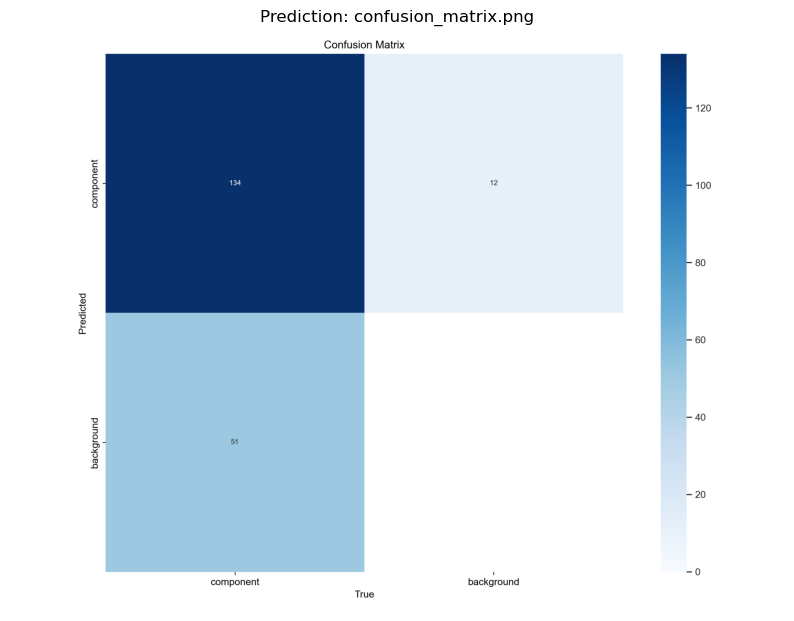

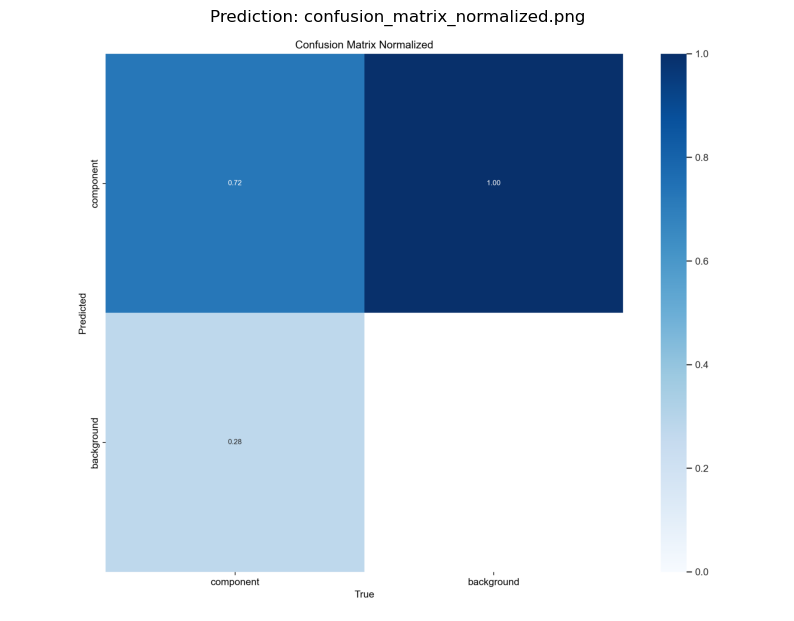

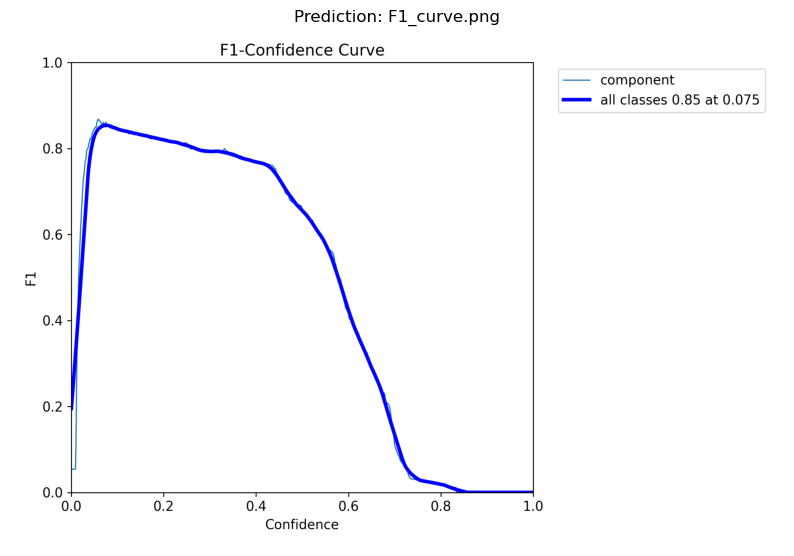

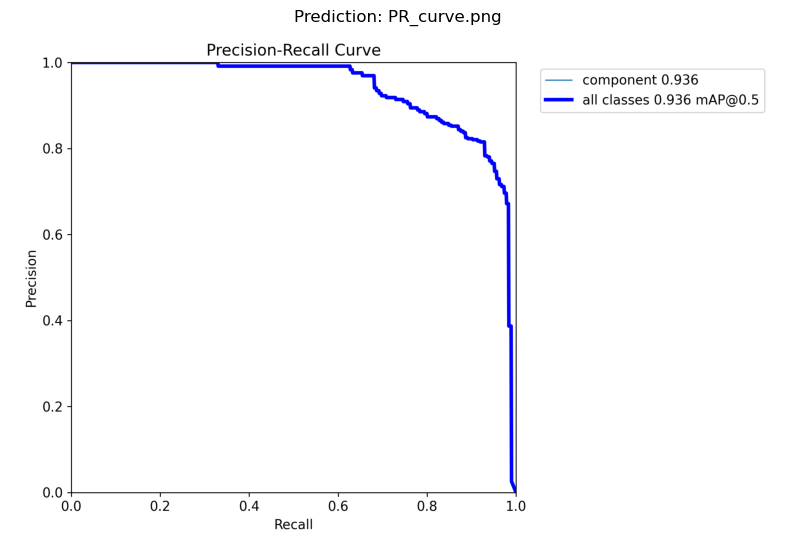

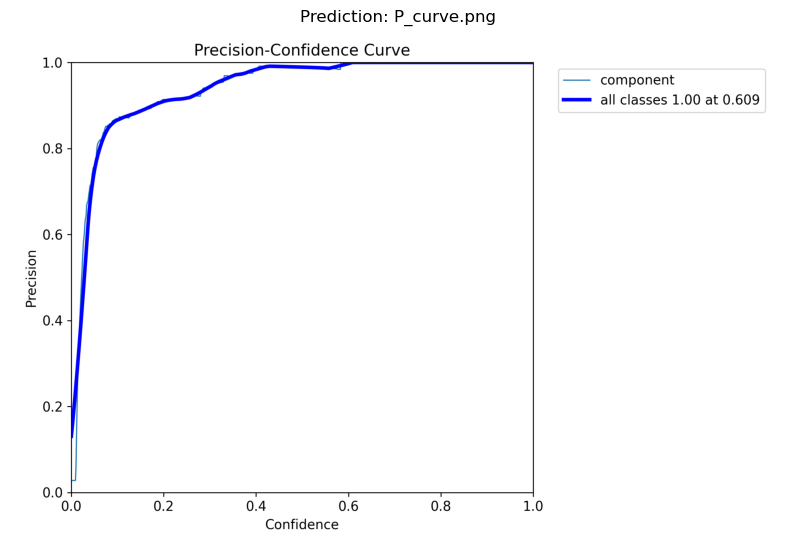

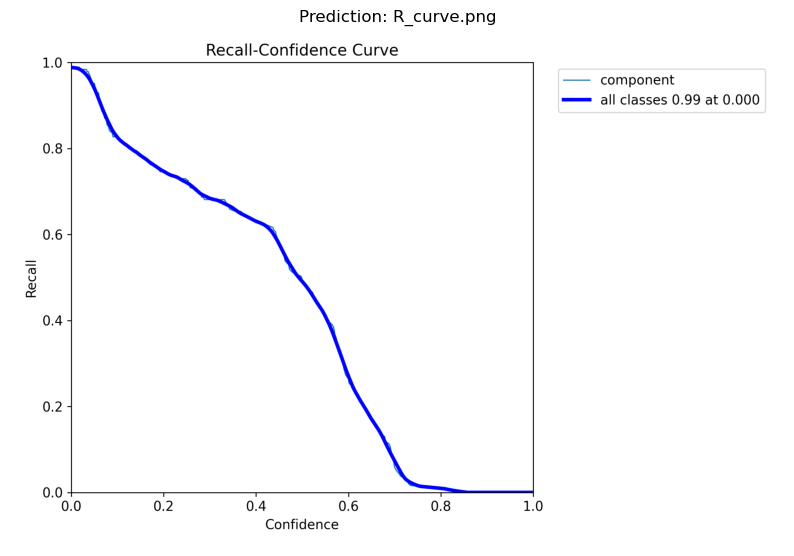

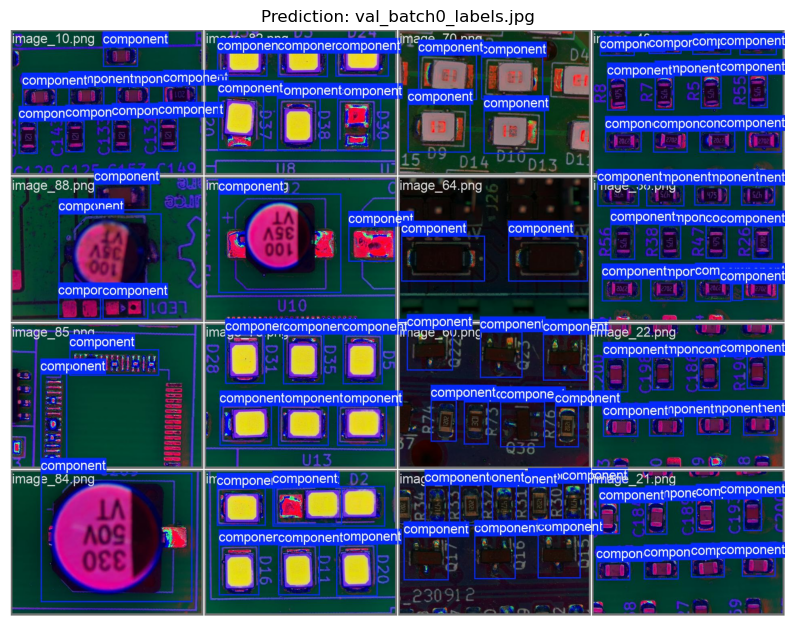

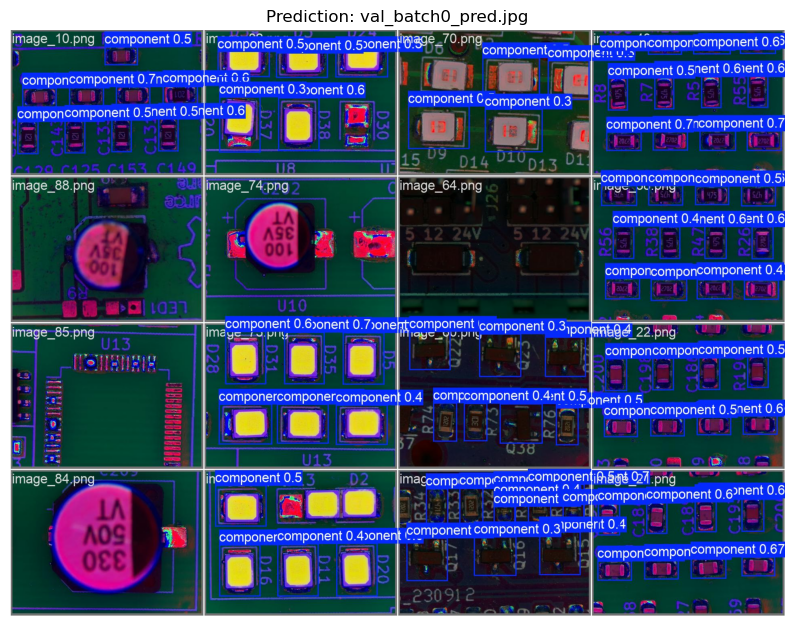

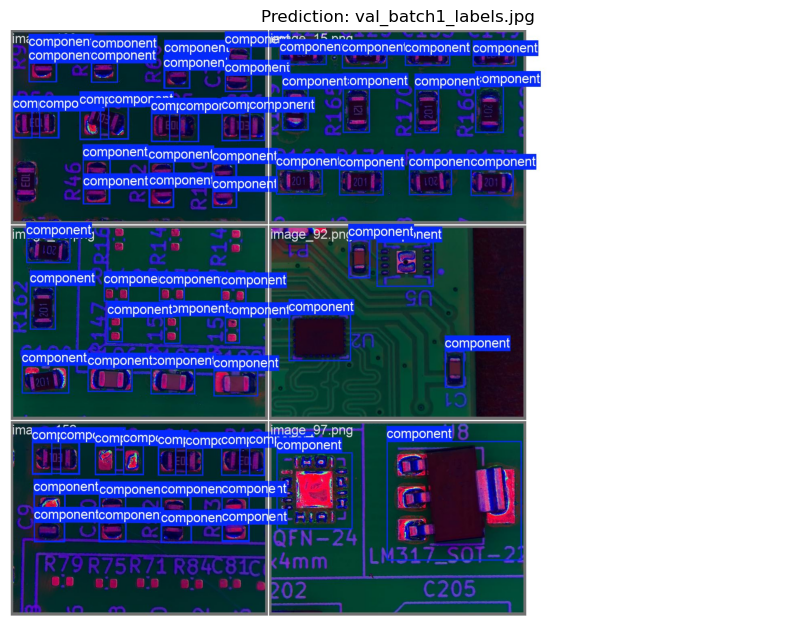

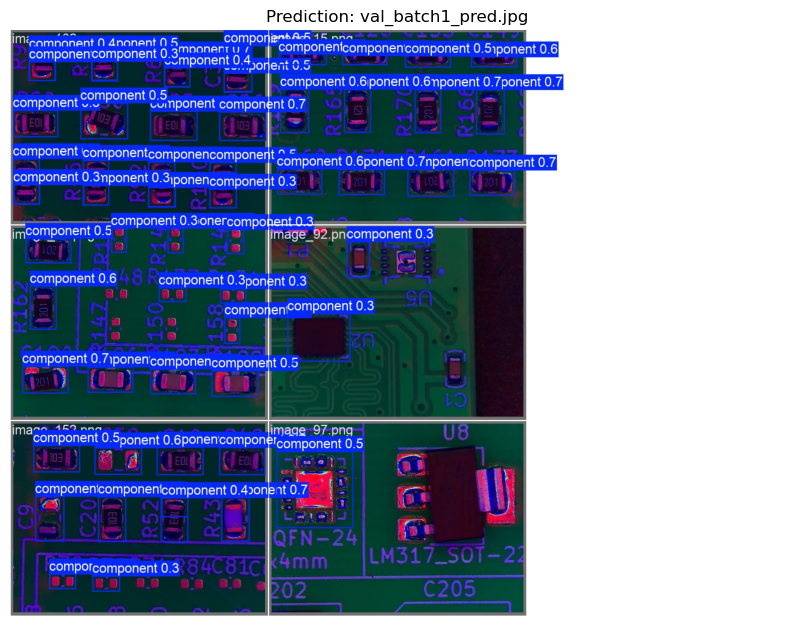

In [23]:
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


# Directory where YOLO saved the results
predictions_dir = r"runs\detect\pcb_detection62"  # Update based on the YOLO output message

# Check if the directory exists
if not os.path.exists(predictions_dir):
    raise FileNotFoundError(f"Directory {predictions_dir} not found. Check the YOLO output path.")

# Show saved validation result images
for image_file in os.listdir(predictions_dir):
    if image_file.endswith(".jpg") or image_file.endswith(".png"):
        image_path = os.path.join(predictions_dir, image_file)

        # Load and display the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Prediction: {os.path.basename(image_file)}")
        plt.show()


## CNN Model

In [36]:
import os
import cv2
import numpy as np

def get_image_size_statistics(dataset_path):
    heights = []
    widths = []
    
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                if image_path.endswith(('.jpg', '.png')):
                    image = cv2.imread(image_path)
                    if image is not None:  # Ensure the image is loaded correctly
                        h, w, _ = image.shape
                        heights.append(h)
                        widths.append(w)
    
    max_height = max(heights)
    max_width = max(widths)
    mean_height = np.mean(heights)
    mean_width = np.mean(widths)
    
    return max_height, max_width, mean_height, mean_width

# Define dataset path
dataset_path = r"E:\Our_Dataset\Cropped_Components"

# Get statistics
max_h, max_w, mean_h, mean_w = get_image_size_statistics(dataset_path)

print(f"Max Height: {max_h}, Max Width: {max_w}")
print(f"Mean Height: {mean_h:.2f}, Mean Width: {mean_w:.2f}")


Max Height: 991, Max Width: 1402
Mean Height: 169.70, Mean Width: 174.93


In [2]:
def pad_image(image, target_size=(300, 300)):
    """
    Pads or resizes the image to match the target size.
    Args:
    - image: Input image (H, W, C)
    - target_size: Tuple (height, width) specifying desired output size
    
    Returns:
    - Padded or resized image of shape (target_size[0], target_size[1], C)
    """
    h, w, c = image.shape
    target_h, target_w = target_size
    
    # If the image is larger, resize it directly
    if h > target_h or w > target_w:
        return cv2.resize(image, target_size)
    
    # Compute padding values
    delta_h = target_h - h
    delta_w = target_w - w
    top = delta_h // 2
    bottom = delta_h - top
    left = delta_w // 2
    right = delta_w - left
    
    # Apply padding
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, 
                                      borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_image

# Load images and apply padding
def load_dataset_with_padding(dataset_path, target_size=(300, 300)):
    images = []
    labels = []
    
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                if image_path.endswith(('.jpg', '.png')):
                    image = cv2.imread(image_path)
                    if image is not None:  # Ensure the image is loaded correctly
                        padded_image = pad_image(image, target_size)
                        images.append(padded_image)
                        labels.append(class_name)
    
    return np.array(images), np.array(labels)

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load and preprocess dataset
dataset_path = r"./Cropped_Components"
images, labels = load_dataset_with_padding(dataset_path)

# Normalize images
images = images / 255.0

# Encode dataset
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)  # Convert class names to integer labels
labels_one_hot = to_categorical(labels_encoded)       # One-hot encode the integer labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels_one_hot, test_size=0.3, random_state=42)

# Print shapes for verification
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (2252, 300, 300, 3), y_train shape: (2252, 9)
X_test shape: (966, 300, 300, 3), y_test shape: (966, 9)


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Dense

def create_color_sensitive_cnn(input_shape, num_classes):
    """
    Creates a CNN model sensitive to color variations.
    
    Args:
    - input_shape: Tuple representing the shape of the input (height, width, channels).
    - num_classes: Number of output classes.
    
    Returns:
    - A compiled CNN model.
    """
    model = Sequential([
        # First convolutional block
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),
        
        # Second convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),
        
        # Third convolutional block
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),
        
        # Fourth convolutional block
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),
        
        # Global Average Pooling
        GlobalAveragePooling2D(),
        
        # Output layer
        Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
    ])
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Define the input shape and number of classes
input_shape = (300, 300, 3)  # Images are padded/resized to 300x300 with 3 channels (RGB)
num_classes = 9  # You specified three main classes: Component Issues, Solder Issues, Good Solder

# Create the model
color_sensitive_cnn_model = create_color_sensitive_cnn(input_shape, num_classes)

# Print the model summary
color_sensitive_cnn_model.summary()

# Train the model
history = color_sensitive_cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=2,
    verbose=1,
    # class_weight=class_weights_dict  # Add class weights here
)

# Evaluate the model
test_loss, test_accuracy = color_sensitive_cnn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

I0000 00:00:1737490335.283862    9960 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6195 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 300, 300,  │        256 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 300, 300,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 300, 300,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 4)   │        256 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 64)  │        256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 300, 300,  │          0 │ conv2d_1[0][0],   │
│                     │ 64)               │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 150, 150,  │          0 │ multiply[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 150, 150,  │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 128) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 1, 8)   │      1,024 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1, 1, 128) │      1,024 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 150, 150,  │          0 │ conv2d_2[0][0],   │
│ (Multiply)          │ 128)              │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 75, 75,    │          0 │ multiply_1[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        512 │ max_pooling2d_1[

 Total params: 1,899,209 (7.24 MB)

 Trainable params: 1,898,185 (7.24 MB)

 Non-trainable params: 1,024 (4.00 KB)

Class Weights: {0: np.float64(3.1277777777777778), 1: np.float64(0.8718544328300426), 2: np.float64(3.524256651017214), 3: np.float64(0.22065451695081326), 4: np.float64(0.9736273238218763), 5: np.float64(3.524256651017214), 6: np.float64(1.0602636534839924), 7: np.float64(7.582491582491582), 8: np.float64(3.0147255689424366)}
Epoch 1/100


I0000 00:00:1737490368.051529   10521 service.cc:148] XLA service 0x7fe57401b840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737490368.051623   10521 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-22 01:42:48.130278: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737490368.487380   10521 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-22 01:42:51.899034: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-22 01:42:52.053336: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_b

   6/1126 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.1208 - loss: 6.6569     

I0000 00:00:1737490376.805633   10521 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1124/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1818 - loss: 6.3399

2025-01-22 01:43:30.327880: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-22 01:43:30.497733: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-22 01:43:30.586332: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 50s 34ms/step - accuracy: 0.1817 - loss: 6.3384 - val_accuracy: 0.0621 - val_loss: 5.0075 - learning_rate: 1.0000e-04
Epoch 2/100
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.1477 - loss: 4.8593 - val_accuracy: 0.2919 - val_loss: 4.0666 - learning_rate: 1.0000e-04
Epoch 3/100
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.2137 - loss: 3.9786 - val_accuracy: 0.2122 - val_loss: 3.5372 - learning_rate: 1.0000e-04
Epoch 4/100
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.2252 - loss: 3.3442 - val_accuracy: 0.3437 - val_loss: 3.0130 - learning_rate: 1.0000e-04
Epoch 5/100
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.3231 - loss: 2.8455 - val_accuracy: 0.3582 - val_loss: 2.8233 - learning_rate: 1.0000e-04
Epoch 6/100
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - accuracy: 0.3173 - loss: 2.5644 - val_accuracy: 0.2981 - val_loss: 2.5384 - learning_rate: 1.0000e-04
Epoch 7/100
 687/1126 ━━━━━━━━━━━━━━━━━━━━ 10s

KeyboardInterrupt: 